In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

import xgboost as xgb

In [3]:
# Default display options
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

In [4]:
# Loading dataset
df = pd.read_csv("../data/HR_capstone_dataset.csv")

In [5]:
# Displaying first 5 rows
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## Initial Dataset Overview

The dataset contains **14,999 employee records** with **10 variables**.

There are:
- 2 continuous variables (satisfaction_level, last_evaluation)
- 6 numerical discrete variables (projects, hours, tenure, accident, promotion, turnover)
- 2 categorical variables (department, salary)

No missing values are present across any columns.

This indicates strong data completeness and reduces the need for imputation strategies.

In [7]:
# Descriptive statistics
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


## Descriptive Statistics Summary

Key observations:

- Average satisfaction level: **0.61**
- Average evaluation score: **0.71**
- Employees work ~**201 hours per month** on average
- Average tenure: **3.5 years**
- Most employees work on **3–5 projects**
- Promotions in last 5 years are rare (~2%)

Turnover rate (target variable):
- **23.8% of employees left**
- **76.2% stayed**

The dataset shows moderate class imbalance, but not severe enough to prevent modeling. However, evaluation metrics beyond accuracy will be important.

In [8]:
# Checking class distribution
df["left"].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

In [9]:
df["left"].value_counts(normalize=True)

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

## Target Variable Distribution

Approximately 24% of employees in the dataset have left the company.

This imbalance suggests that:

- Accuracy alone may be misleading.
- Metrics such as recall, precision, and ROC-AUC should be prioritized.
- Stratified sampling will be used during train-test split.

## Analytical Observations
1. Typo in *average_montly_hours*
2. Promotion rate is very low as mean = 0.021, i.e., only ~2% promoted in the last 5 years
3. Work accident = 14%, could correlate with retention
4. Satisfaction Level range min = 0.09 whereas max = 1. Wide distribution, hence could be a strong predictor

In [10]:
# Checking for duplicates
df.duplicated().sum()

np.int64(3008)

## Duplicate Records Check
The dataset contains 3008 duplicate rows which is approximately 20% of the total records.

Duplicate employee entries can distort model performance and bias evaluation results

To ensure the integrity of the model, duplicate rows will be removed

In [11]:
# Removing duplicate rows
df = df.drop_duplicates()

# Confirming removal
df.duplicated().sum()

np.int64(0)

In [12]:
df.shape

(11991, 10)

In [13]:
# Standardizing column names
df.columns = df.columns.str.lower().str.strip()

# Fixing misspelled column name
df = df.rename(columns={"average_montly_hours": "average_monthly_hours",
                        "work_accident": "work_accident"})

df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

# Exploratory Data Analysis (EDA)

The goal of this stage is to understand patterns in employee turnover and identify potential predictors for modeling.

Beginning by examining:

- Class balance of the target variable
- Relationships between turnover and key features
- Distribution patterns of numerical variables

In [14]:
df["left"].value_counts()

left
0    10000
1     1991
Name: count, dtype: int64

In [15]:
df["left"].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

## Updated Target Distribution (After Removing Duplicates)

- Employees who stayed: 10,000 (83.4%)
- Employees who left: 1,991 (16.6%)

The dataset shows moderate class imbalance.

Implication for modeling:
- Accuracy alone may be misleading.
- Recall for employees who left will be particularly important.
- Stratified sampling will be used during train-test split.

In [16]:
df.groupby("left")["satisfaction_level"].mean()

left
0    0.667365
1    0.440271
Name: satisfaction_level, dtype: float64

## Satisfaction Level vs Turnover

Average satisfaction level:

- Stayed employees: 0.667
- Employees who left: 0.440

There is a substantial gap in satisfaction between employees who stayed and those who left.

This suggests that satisfaction level is likely one of the strongest predictors of turnover and will be a key feature in modeling.

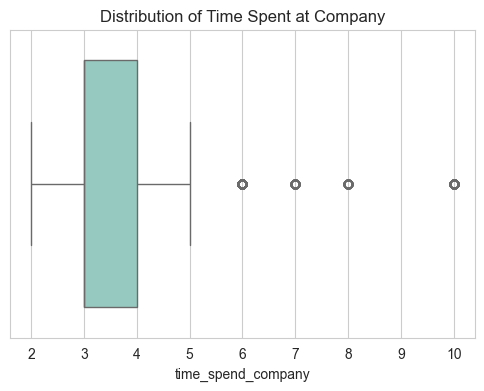

In [17]:
# Visualizing distribution of time spent at company to detect outliers
plt.figure(figsize=(6,4))
sns.boxplot(x=df["time_spend_company"])
plt.title("Distribution of Time Spent at Company")
plt.show()

In [18]:
# Calculating IQR for time_spend_company
Q1 = df["time_spend_company"].quantile(0.25)
Q3 = df["time_spend_company"].quantile(0.75)
IQR = Q3 - Q1

# Defining lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Identifying outliers

outliers = df[(df["time_spend_company"] < lower_bound) |
              (df["time_spend_company"] > upper_bound)]

len(outliers)

824

## Outlier Detection: Time Spent at Company

Using the IQR method, 824 observations were identified as potential outliers in *time_spend_company*.

These represent employees with significantly longer tenure (typically 6+ years).

These are not data errors as they represent real long-tenured employees.

Since tree-based models (Random Forest, XGBoost) are robust to outliers, and tenure itself may be an important predictor, these observations will be retained for modeling.

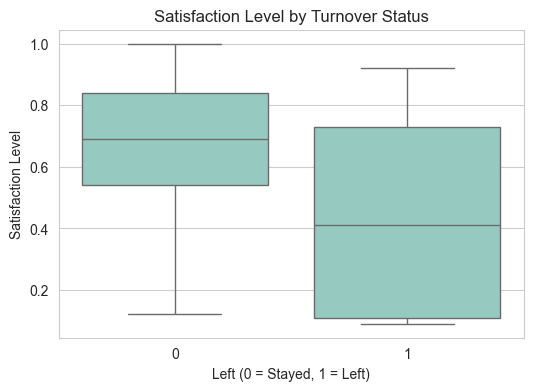

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x="left", y="satisfaction_level", data=df)
plt.title("Satisfaction Level by Turnover Status")
plt.xlabel("Left (0 = Stayed, 1 = Left)")
plt.ylabel("Satisfaction Level")
plt.show()

## Interpretation: Satisfaction Level Distribution

The boxplot reveals a clear separation between employees who stayed and those who left.

Employees who stayed tend to have higher satisfaction levels, with the median around 0.68.

Employees who left show significantly lower satisfaction, with a median near 0.40 and a wider spread in the lower range.

This visual confirms that satisfaction level is strongly associated with turnover and is likely to be one of the most influential predictors in the model.

In [20]:
df.groupby("left")["average_monthly_hours"].mean()

left
0    198.94270
1    208.16223
Name: average_monthly_hours, dtype: float64

In [21]:
df.groupby("left")["number_project"].mean()

left
0    3.786800
1    3.883476
Name: number_project, dtype: float64

## Workload Analysis: Hours and Projects

Average monthly hours:
- Stayed employees: 198.9 hours
- Employees who left: 208.2 hours

Employees who left worked approximately 9 additional hours per month on average.

Number of projects:
- Stayed employees: 3.79 projects
- Employees who left: 3.88 projects

Project count shows only a minor difference, but average monthly hours suggest that workload intensity may contribute to turnover.

Further visualization is required to understand whether extreme workloads are driving attrition.

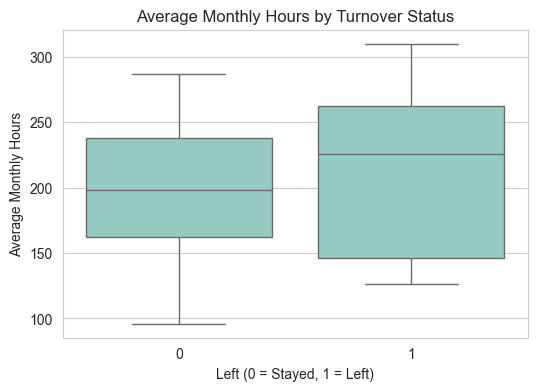

In [22]:
# Visualizing distribution of average monthly hours by turnover status
plt.figure(figsize=(6,4))
sns.boxplot(x="left", y="average_monthly_hours", data=df)
plt.title("Average Monthly Hours by Turnover Status")
plt.xlabel("Left (0 = Stayed, 1 = Left)")
plt.ylabel("Average Monthly Hours")
plt.show()

## Interpretation: Workload and Turnover

The boxplot shows that employees who left tend to have higher monthly working hours.

Key observations:

- The median monthly hours for employees who left is noticeably higher.
- There is greater spread in working hours among employees who left.
- A cluster of high-hour employees (250+ hours/month) appears more common in the turnover group.

This suggests that excessive workload may contribute to employee burnout and eventual departure.

While the difference in project count was minimal, intensity of work (hours) appears to be a stronger indicator of attrition risk.

In [23]:
df.groupby("left")["time_spend_company"].mean()

left
0    3.262000
1    3.881467
Name: time_spend_company, dtype: float64

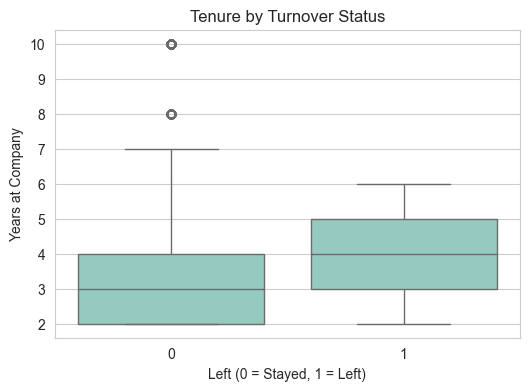

In [24]:
# Visualizing tenure by turnover status
plt.figure(figsize=(6,4))
sns.boxplot(x="left", y="time_spend_company", data=df)
plt.title("Tenure by Turnover Status")
plt.xlabel("Left (0 = Stayed, 1 = Left)")
plt.ylabel("Years at Company")
plt.show()

## Interpretation: Tenure and Turnover

Employees who left have a higher average tenure (3.88 years) compared to those who stayed (3.26 years).

The distribution suggests a mid-career exit pattern:

- Many departures occur around 3–5 years.
- Very long-tenured employees (8+ years) are less likely to leave.

This may indicate that employees reassess career growth opportunities after several years at the company.

Tenure appears to be an important predictive variable, potentially with non-linear effects.

In [25]:
df.groupby("left")["promotion_last_5years"].mean()

left
0    0.019500
1    0.004018
Name: promotion_last_5years, dtype: float64

In [26]:
pd.crosstab(df["promotion_last_5years"], df["left"], normalize="index")

left,0,1
promotion_last_5years,,
0,0.831778,0.168222
1,0.960591,0.039409


## Interpretation: Promotion and Turnover

Promotion appears to significantly reduce employee turnover.

Findings:

- Only 0.4% of employees who left had been promoted in the last 5 years.
- Among employees who were promoted, only 3.9% left.
- Among employees who were not promoted, 16.8% left.

This suggests that career advancement opportunities play a major role in retention.

Promotion status is likely to be an important predictive feature and a key lever for HR strategy.

In [27]:
pd.crosstab(df["salary"], df["left"], normalize="index")

left,0,1
salary,,
high,0.951515,0.048485
low,0.795470,0.204530
medium,0.853830,0.146170


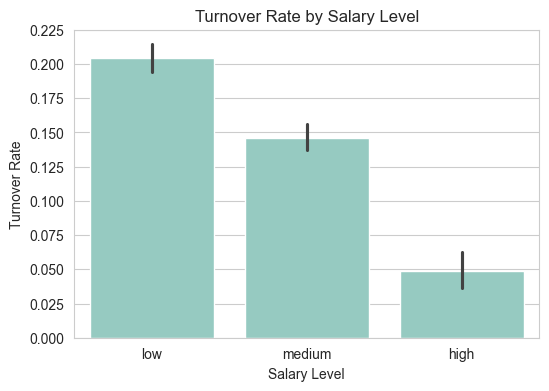

In [28]:
# Visualizing turnover rate by salary level
plt.figure(figsize=(6,4))
sns.barplot(x="salary", y="left", data=df, order=["low", "medium", "high"])
plt.title("Turnover Rate by Salary Level")
plt.xlabel("Salary Level")
plt.ylabel("Turnover Rate")
plt.show()

## Interpretation: Salary and Turnover

Turnover rates decrease significantly as salary level increases:

- Low salary employees show the highest turnover (~20%)
- Medium salary employees show moderate turnover (~14%)
- High salary employees show very low turnover (~5%)

This suggests compensation level is strongly associated with retention.

Salary appears to be one of the most actionable business levers for reducing attrition.

In [29]:
# Calculating turnover rate by department
dept_turnover = pd.crosstab(df["department"], df["left"], normalize="index")
dept_turnover

left,0,1
department,,
IT,0.838115,0.161885
RandD,0.877522,0.122478
accounting,0.824477,0.175523
hr,0.811980,0.188020
management,0.880734,0.119266
marketing,0.833581,0.166419
product_mng,0.839650,0.160350
sales,0.830195,0.169805
support,0.828666,0.171334


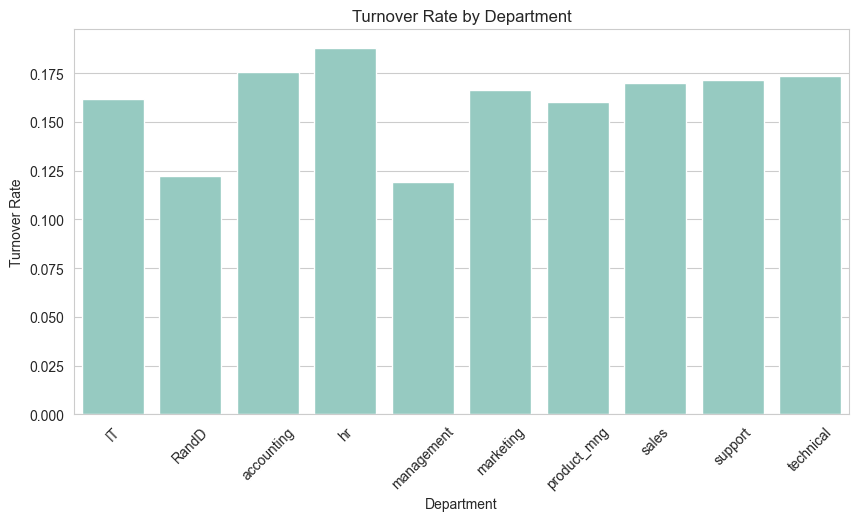

In [30]:
# Visualizing turnover rate by department
plt.figure(figsize=(10,5))
sns.barplot(x=dept_turnover.index,
            y=dept_turnover[1])
plt.xticks(rotation=45)
plt.title("Turnover Rate by Department")
plt.xlabel("Department")
plt.ylabel("Turnover Rate")
plt.show()

## Interpretation: Department and Turnover

Turnover rates vary moderately across departments but remain within a relatively narrow range (~12% to ~19%).

Observations:

- HR shows one of the highest turnover rates (~18.8%).
- Accounting, technical, and support roles also show elevated turnover.
- Management and R&D show comparatively lower turnover (~12%).

While department contributes some variation, it does not appear to be as strong a predictor as satisfaction, promotion status, or salary.

This suggests that turnover may be more influenced by individual-level factors (satisfaction, workload, compensation) than by department alone.

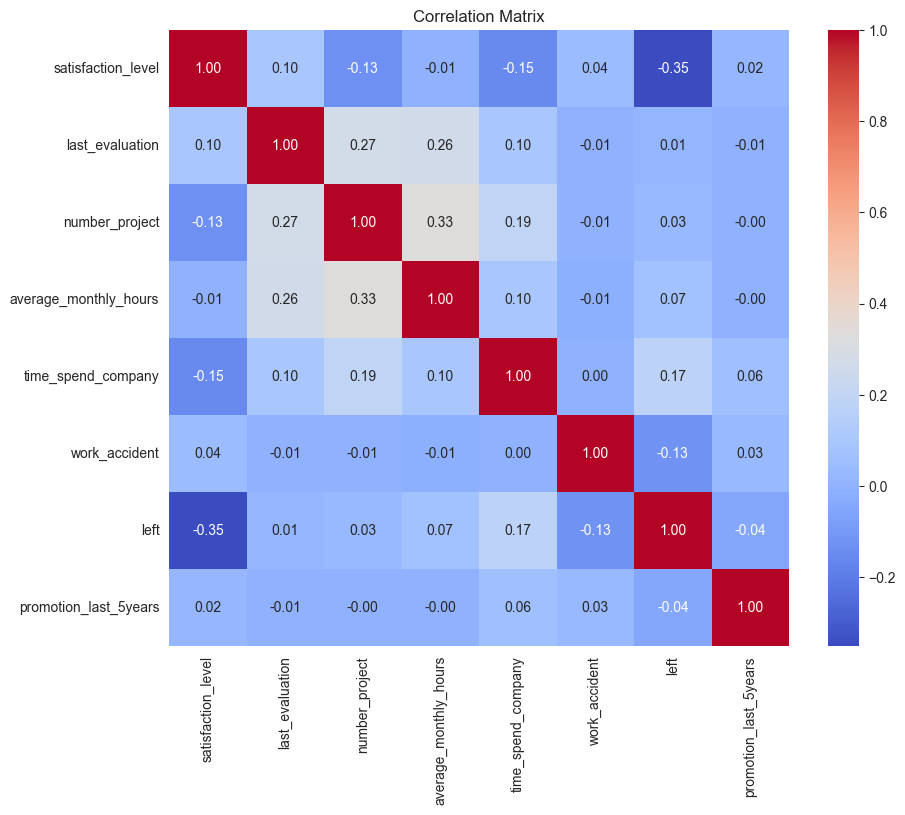

In [31]:
# Selecting only numerical variables
numerical_df = df.select_dtypes(include=["int64", "float64"])

# Computing correlation matrix
corr_matrix = numerical_df.corr()

# Visualizing correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Interpretation: Correlation Analysis

The strongest correlation with turnover (`left`) is:

- Satisfaction level: **-0.35**

This indicates a moderate negative relationship — as satisfaction increases, turnover decreases.

Other notable correlations with turnover:

- Time spent at company: +0.17
- Work accident: -0.13
- Average monthly hours: +0.07 (weak)

Most other correlations are relatively weak (< 0.10), suggesting that turnover is influenced by multiple interacting factors rather than a single dominant numeric variable.

Importantly:

- There is no severe multicollinearity among predictor variables.
- The strongest relationships appear behaviorally meaningful (satisfaction, tenure).

This supports proceeding with predictive modeling.

# Model Preparation

Preparing features for predictive modeling.

Steps:
- Separating target variable
- Encoding categorical variables
- Splitting data into training and testing sets
- Ensuring stratified sampling due to class imbalance

In [32]:
# Separating features and target variable
X = df.drop("left", axis=1)
y = df["left"]

# One-hot encoding categorical variables (department and salary)
X = pd.get_dummies(X, columns=["department", "salary"], drop_first=True)

# Checking final feature set shape
X.shape

(11991, 18)

In [33]:
# Splitting data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Checking distribution in training set
y_train.value_counts(normalize=True)

left
0    0.833924
1    0.166076
Name: proportion, dtype: float64

# Model 1: Logistic Regression

Building a baseline logistic regression model to:

- Establish interpretability
- Identify direction and strength of predictors
- Provide a statistical benchmark before moving to ensemble models

In [34]:
# Initializing logistic regression model with class balancing
log_model = LogisticRegression(max_iter=1000, class_weight="balanced")

# Training the model
log_model.fit(X_train, y_train)

# Generating predictions
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

# Evaluating model performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred_log))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_log))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob_log))

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      2001
           1       0.43      0.84      0.57       398

    accuracy                           0.79      2399
   macro avg       0.70      0.81      0.71      2399
weighted avg       0.87      0.79      0.81      2399


Confusion Matrix:

[[1554  447]
 [  62  336]]

ROC-AUC Score:
0.8484011762962739


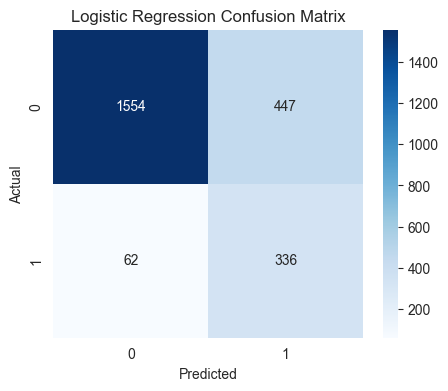

In [35]:
# Visualizing confusion matrix for logistic regression

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_log),
            annot=True,
            fmt="d",
            cmap="Blues")

plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Interpretation: Logistic Regression Performance

The model correctly identifies 336 employees who left (true positives) and 1554 who stayed (true negatives).

However, it incorrectly flags 447 employees as likely to leave (false positives).

The model prioritizes recall for at-risk employees, which may be desirable in an HR context where missing a potential departure is costlier than conducting an unnecessary retention conversation.

Overall, logistic regression provides a strong and interpretable baseline with an ROC-AUC of 0.85.

# Model 2: Random Forest

Building a Random Forest classifier to:

- Capture non-linear relationships
- Improve precision compared to logistic regression
- Identify feature importance
- Compare performance against the baseline model

In [36]:
# Initializing Random Forest with class balancing
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

# Training the model
rf_model.fit(X_train, y_train)

# Generating predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluating model performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_rf))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob_rf))

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2001
           1       0.99      0.92      0.95       398

    accuracy                           0.99      2399
   macro avg       0.99      0.96      0.97      2399
weighted avg       0.99      0.99      0.99      2399


Confusion Matrix:

[[1997    4]
 [  31  367]]

ROC-AUC Score:
0.9791435940321297


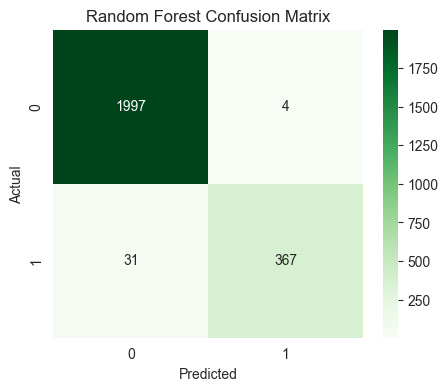

In [37]:
# Visualizing confusion matrix for Random Forest

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True,
            fmt="d",
            cmap="Greens")

plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Interpretation: Random Forest Performance

The Random Forest model demonstrates extremely strong predictive performance:

- 367 true positives (employees correctly predicted to leave)
- Only 31 false negatives
- Only 4 false positives

With an ROC-AUC of 0.98, the model shows excellent class separation.

Compared to logistic regression, Random Forest significantly improves both precision and recall for predicting employee turnover.

This suggests that non-linear relationships and feature interactions play an important role in predicting attrition.

In [38]:
# Extracting feature importance from Random Forest
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

feature_importance.head(10)

satisfaction_level       0.282059
time_spend_company       0.236517
number_project           0.155147
average_monthly_hours    0.143990
last_evaluation          0.137111
work_accident            0.009962
salary_low               0.007383
department_sales         0.004326
salary_medium            0.004264
department_technical     0.003744
dtype: float64

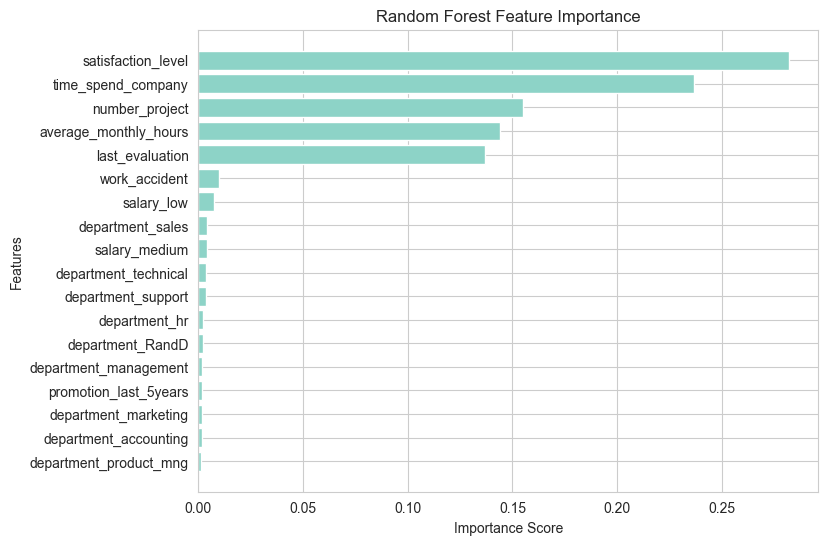

In [39]:
# Sorting feature importance values
feature_importance_sorted = feature_importance.sort_values(ascending=True)

# Visualizing feature importance
plt.figure(figsize=(8,6))
plt.barh(feature_importance_sorted.index, feature_importance_sorted.values)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

## Feature Importance: Random Forest

The most influential predictors of employee turnover are:

1. Satisfaction level
2. Time spent at company
3. Number of projects
4. Average monthly hours
5. Last evaluation score

Compensation and department features show comparatively low importance.

This suggests that behavioral and workload-related factors drive turnover more strongly than organizational structure alone.

The dominance of satisfaction and tenure explains the high predictive performance of the Random Forest model.

# Model 3: XGBoost

Building an XGBoost classifier to:

- Further optimize predictive performance
- Compare boosting vs bagging approaches
- Determine whether performance improves beyond Random Forest

In [40]:
# Initializing XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
)

# Training the model
xgb_model.fit(X_train, y_train)

# Generating predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluating model performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob_xgb))

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2001
           1       0.92      0.93      0.93       398

    accuracy                           0.98      2399
   macro avg       0.96      0.96      0.96      2399
weighted avg       0.98      0.98      0.98      2399


Confusion Matrix:

[[1970   31]
 [  26  372]]

ROC-AUC Score:
0.981358566947682


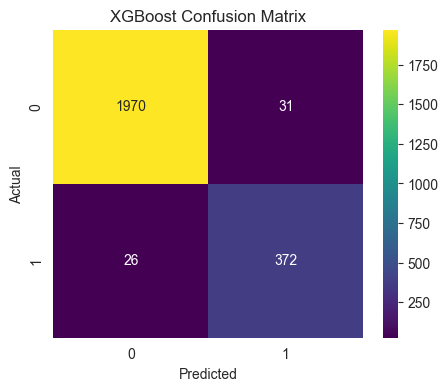

In [41]:
# Visualizing confusion matrix for XGBoost

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),
            annot=True,
            fmt="d",
            cmap="viridis")

plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Model Comparison and Selection

Three models were evaluated:

1. Logistic Regression (baseline statistical model)
2. Random Forest (ensemble bagging method)
3. XGBoost (gradient boosting model)

## Performance Summary

Logistic Regression:
- Accuracy: 79%
- Recall (left): 84%
- ROC-AUC: 0.85

Random Forest:
- Accuracy: 99%
- Recall (left): 92%
- ROC-AUC: 0.98

XGBoost:
- Accuracy: 98%
- Recall (left): 93%
- ROC-AUC: 0.98

## Interpretation

Logistic regression provides interpretability but underperforms compared to tree-based models.

Both Random Forest and XGBoost significantly improve predictive performance by capturing non-linear relationships between features.

XGBoost slightly improves recall for employees who left, reducing false negatives compared to Random Forest.

## Final Model Selection

Given that missing at-risk employees is more costly than conducting unnecessary retention outreach, recall is prioritized.

Therefore, XGBoost is selected as the final model for predicting employee turnover.

# Business Insights and Recommendations

## Key Drivers of Turnover

The key drivers that influence turnover are:

- Low satisfaction level
- Mid-range tenure (3-5 years)
- Higher monthly working hours
- Higher project load
- Lack of promotion opportunities
- Lower salary levels

Turnover is driven by workload intensity and employee satisfaction, and not by the department.

## Strategic Recommendations

1. Tracking Satisfaction Trends
   Track employee satisfaction scores and look for sudden dips.

2. Mid-Career Turnover
   Employees with 3-5 years of service may need special attention or development opportunities.

3. Workload Intensity
   High working hours are associated with high turnover.

4. Promotion Opportunities
   Employees who have been promoted have shown significantly lower turnover rates.

5. Compensation Review
   Low salaries are strongly associated with high turnover.

## Model Deployment Considerations

- The model should be used for proactive retention discussions.
- It should not be used for punitive purposes.
- Periodic retraining is recommended to ensure accuracy.
- Additional data (satisfaction trends, manager feedback, exit interviews) could be used to improve predictions.